In [4]:
import numpy as np

import h5py
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
from scipy.ndimage import shift as shift_image
#from skimage import exposure
import json
import re
import os

# Function to read displacement field from an h5 file
def read_displacement_field_h5(file_path):
    with h5py.File(file_path, 'r') as f:
        displacement_field = f['image'][:]
    return displacement_field

# Function to compute the intensity of the vector field
def compute_intensity(displacement_field, z_plane):
    # Extract the vector components for the given z-plane
    dz = displacement_field[z_plane, :, :, 0]
    dy = displacement_field[z_plane, :, :, 1]
    dx = displacement_field[z_plane, :, :, 2]
    
    # Compute the magnitude of the vectors
    intensity = np.sqrt(dx**2 + dy**2 + dz**2)
    return intensity

# Function to read image using SimpleITK
def read_image(file_path):
    return sitk.GetArrayFromImage(sitk.ReadImage(file_path))

# Load the displacement field from an h5 file
path="/home/marcnol/grey/users/marcnol/DEEDs_test/dataset-deformation/shifted_dataset_small"
DF_path=path+"/register_local/data"
file_path = DF_path+'/scan_001_RT251_001_ROI_converted_decon_ch00_DF.h5'
print(f'$ attempt to read: {file_path}')
displacement_field = read_displacement_field_h5(file_path)

print(f'DF read, dims={displacement_field.shape}')

# loads moving image
moving_file_path = path+'/scan_001_RT25_001_ROI_converted_decon_ch00.tif'
print(f'$ attempt to read: {moving_file_path}')

moving_image = read_image(moving_file_path)
moving_image_2d = moving_image[z_plane, :, :]


$ attempt to read: /home/marcnol/grey/users/marcnol/DEEDs_test/dataset-deformation/shifted_dataset_small/register_local/data/scan_001_RT251_001_ROI_converted_decon_ch00_DF.h5
DF read, dims=(60, 512, 512, 3)
$ attempt to read: /home/marcnol/grey/users/marcnol/DEEDs_test/dataset-deformation/shifted_dataset_small/scan_001_RT25_001_ROI_converted_decon_ch00.tif


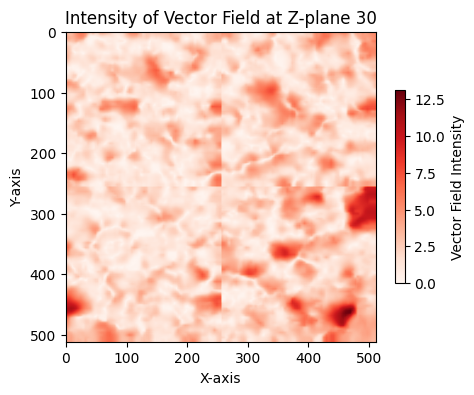

In [35]:
# Choose a z-plane to visualize
z_plane = int(displacement_field.shape[0]/2)  # Change this to the desired z-plane

# Compute the intensity of the vector field
intensity = compute_intensity(displacement_field, z_plane)

# Plot the intensity as a 2D image
plt.figure(figsize=(5, 5))
plt.imshow(intensity, cmap='Reds')
plt.colorbar(label='Vector Field Intensity', shrink=0.5)
plt.title(f'Intensity of Vector Field at Z-plane {z_plane}')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

Optimal Threshold using Otsu's Method (scikit-image): 1228


/tmp/ipykernel_483530/3758484486.py:12: UserWarning: otsu_thresholded_image_skimage.png is a low contrast image
  io.imsave('otsu_thresholded_image_skimage.png', binary_image.astype('uint8') * 255)


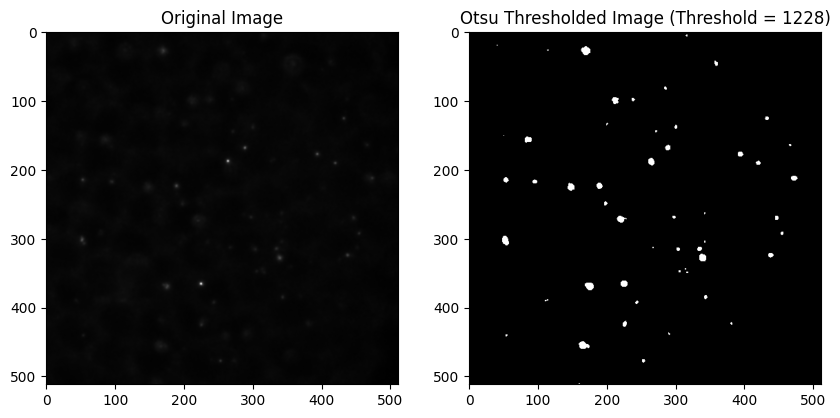

In [6]:


from skimage import io, filters
import matplotlib.pyplot as plt

# Load grayscale image using scikit-image
image = moving_image[30]

# Apply Otsu's thresholding
otsu_threshold = filters.threshold_otsu(image)
binary_image = image > otsu_threshold

# Save the thresholded image
io.imsave('otsu_thresholded_image_skimage.png', binary_image.astype('uint8') * 255)

# Print the threshold value
print(f"Optimal Threshold using Otsu's Method (scikit-image): {otsu_threshold}")

# Plot the original image and the thresholded image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(binary_image, cmap='gray')
plt.title(f'Otsu Thresholded Image (Threshold = {otsu_threshold})')
plt.show()


## finds focus

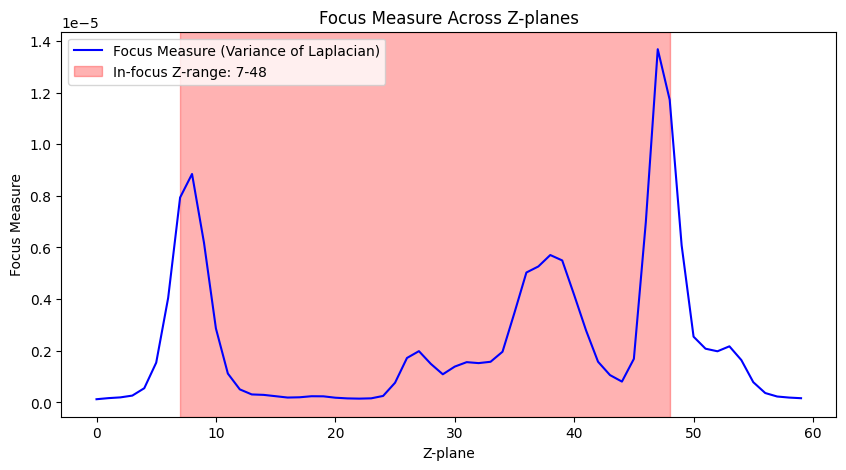

In-focus Z-range: 7 to 48


In [43]:
import numpy as np
from skimage import io
from skimage.filters import laplace
import matplotlib.pyplot as plt

def calculate_focus_measure(image_3d):
    """
    Calculate the focus measure (variance of Laplacian) for each Z-plane in the 3D image.
    
    Parameters:
    - image_3d: 3D numpy array (Z, Y, X) representing the image stack.

    Returns:
    - focus_measures: List of focus measures (variance of Laplacian) for each Z-plane.
    """
    focus_measures = []
    
    for i in range(image_3d.shape[0]):
        plane = image_3d[i, :, :]
        laplacian = laplace(plane)
        focus_measure = np.var(laplacian)
        focus_measures.append(focus_measure)
    
    return focus_measures

def calculate_focus_z_range(image_3d, threshold_factor=0.5):
    """
    Calculate the Z-range over which the image has objects that are in focus.
    
    Parameters:
    - image_3d: 3D numpy array (Z, Y, X) representing the image stack.
    - threshold_factor: A factor of the maximum focus measure to determine which planes are in focus (default: 0.5).
    
    Returns:
    - z_range: Tuple indicating the start and end Z-slices where objects are considered in focus.
    """
    # Calculate focus measures for each Z-plane
    focus_measures = calculate_focus_measure(image_3d)
    
    # Determine the threshold to consider a plane as in focus
    max_focus_measure = max(focus_measures)
    threshold = max_focus_measure * threshold_factor
    
    # Find the Z-planes that are in focus
    in_focus_planes = [i for i, measure in enumerate(focus_measures) if measure >= threshold]
    
    if len(in_focus_planes) == 0:
        return None, None  # No in-focus planes found
    
    # Calculate the Z-range where the image is in focus
    z_start = min(in_focus_planes)
    z_end = max(in_focus_planes)
    
    return z_start, z_end, focus_measures

def plot_focus_measure(focus_measures, z_start, z_end):
    """
    Plot the focus measure for each Z-plane with the Z-range in focus highlighted.
    
    Parameters:
    - focus_measures: List of focus measures for each Z-plane.
    - z_start: The start Z-plane where objects are in focus.
    - z_end: The end Z-plane where objects are in focus.
    """
    plt.figure(figsize=(10, 5))
    plt.plot(focus_measures, label='Focus Measure (Variance of Laplacian)', color='blue')
    plt.axvspan(z_start, z_end, color='red', alpha=0.3, label=f'In-focus Z-range: {z_start}-{z_end}')
    plt.xlabel('Z-plane')
    plt.ylabel('Focus Measure')
    plt.title('Focus Measure Across Z-planes')
    plt.legend()
    plt.show()

def find_focus_z_range(image_3d, threshold_factor=0.5):
    """
    Load a 3D image, calculate the Z-range of in-focus planes, and plot the focus measure.
    
    Parameters:
    - image_path: Path to the 3D image.
    - threshold_factor: Factor of maximum focus measure to determine in-focus planes.
    
    Returns:
    - z_start: Start of in-focus Z-range.
    - z_end: End of in-focus Z-range.
    """
    
    # Calculate the in-focus Z-range
    z_start, z_end, focus_measures = calculate_focus_z_range(image_3d, threshold_factor)
    
    # Plot the focus measures and in-focus range
    plot_focus_measure(focus_measures, z_start, z_end)
    
    print(f"In-focus Z-range: {z_start} to {z_end}")
    
    return z_start, z_end

# Example usage:
z_start, z_end = find_focus_z_range(moving_image)


### overlays DF intensity to DAPI image

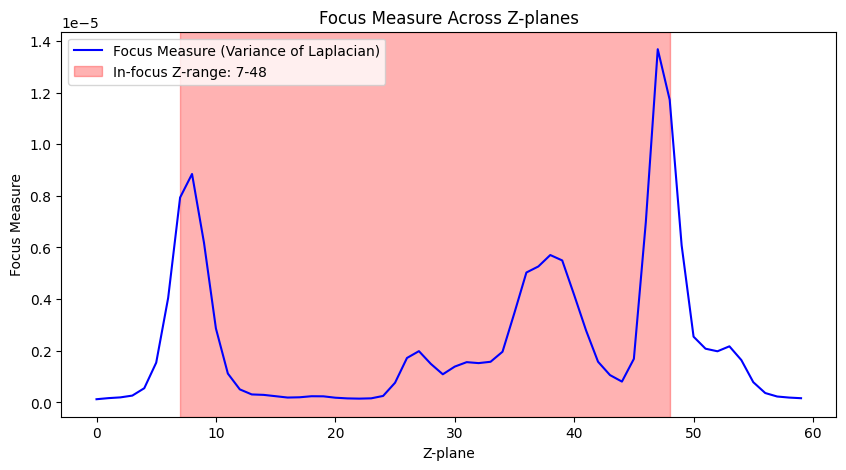

In-focus Z-range: 7 to 48


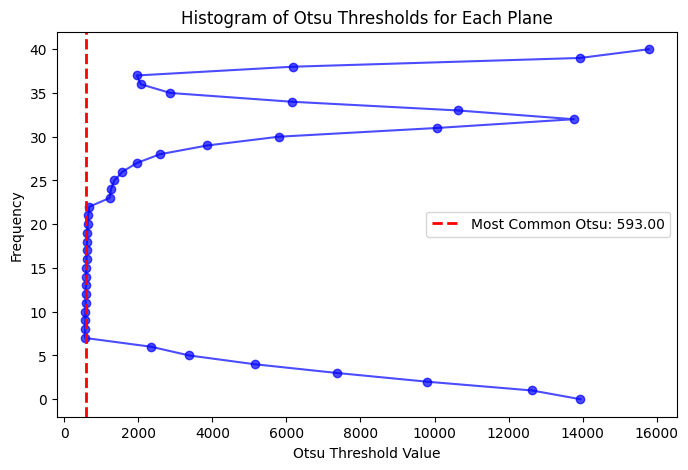

$ optimal 3d otsu threshold = 593


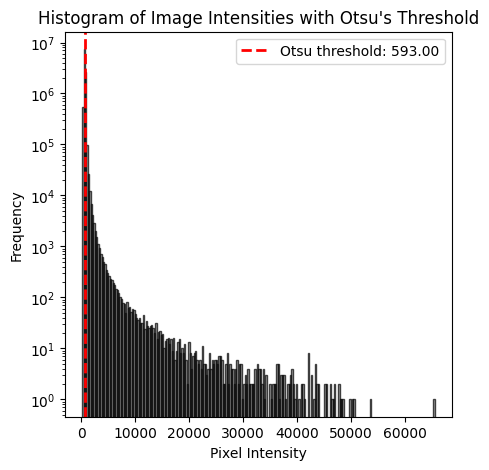

$ optimal 3d otsu threshold = 593


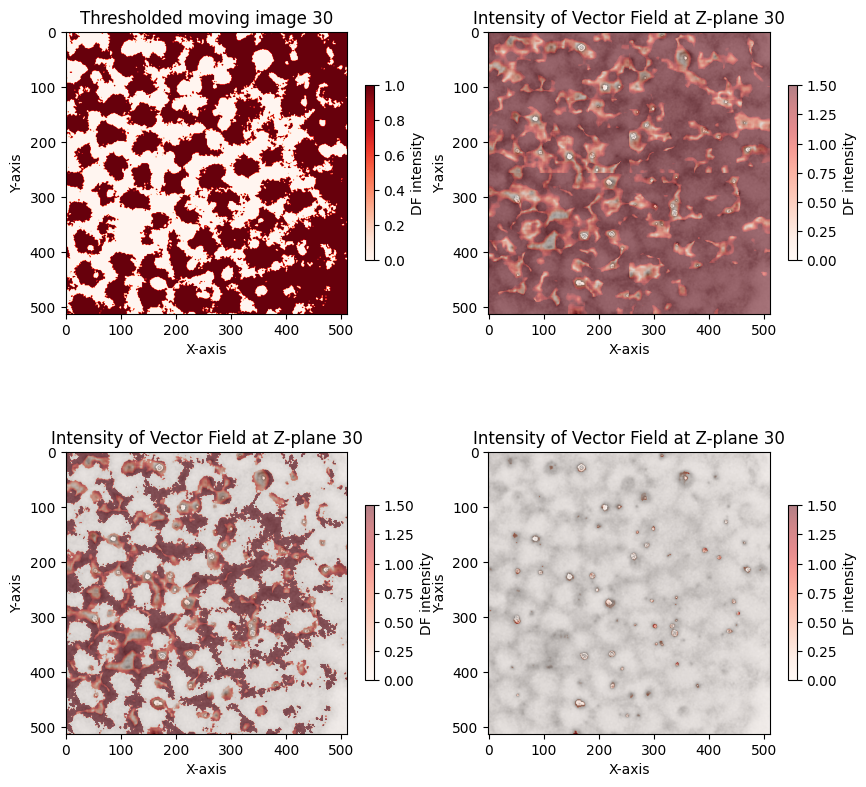

In [47]:
from skimage import io, filters
from skimage.filters import threshold_otsu
from collections import Counter

# functions
def thresholds_DF(displacement_field, mask):
    df = displacement_field.copy()
    df[mask] = 0
    return df

def finds_otsu_threshold(image):
    otsu_threshold = filters.threshold_otsu(image)
    print(f"$ optimal 2d otsu threshold = {otsu_threshold}")
    return otsu_threshold


def calculate_most_common_otsu(image_3d, plotting=False):
    """
    Calculate the Otsu threshold for each plane in a 3D image and return the most common threshold.

    Parameters:
    - image_3d: The input 3D image as a numpy array.

    Returns:
    - most_common_threshold: The most common Otsu threshold across all planes.
    """
    # List to store Otsu thresholds for each plane
    otsu_thresholds = []

    # Iterate through each plane (2D slice) and calculate the Otsu threshold
    for i in range(image_3d.shape[0]):
        plane = image_3d[i, :, :]
        otsu_threshold = threshold_otsu(plane)
        otsu_thresholds.append(otsu_threshold)

    # Get the most common Otsu threshold
    
    threshold_counts = Counter(otsu_thresholds)
    most_common_threshold = threshold_counts.most_common(1)[0][0]
    #most_common_threshold=np.median(otsu_thresholds)

    if plotting:
        # Plot histogram of Otsu values
        plt.figure(figsize=(8, 5))
        #plt.hist(otsu_thresholds, bins=40, color='blue', alpha=0.7, edgecolor='black')
        plt.plot(otsu_thresholds, range(image_3d.shape[0]), 'o-', color='blue', alpha=0.7)
        plt.axvline(most_common_threshold, color='red', linestyle='dashed', linewidth=2, label=f'Most Common Otsu: {most_common_threshold:.2f}')
        plt.title('Histogram of Otsu Thresholds for Each Plane')
        plt.xlabel('Otsu Threshold Value')
        plt.ylabel('Frequency')
        plt.legend()
        plt.show()
    
    print(f"$ optimal 3d otsu threshold = {most_common_threshold}")

    return most_common_threshold

def plot_histogram_with_otsu(image_3d, bins=256):
    """
    Plot the histogram of intensities for a 3D image and the Otsu threshold.

    Parameters:
    - image_path: The path to the 3D image file.
    - bins: The number of bins for the histogram (default: 256).
    """

    # Flatten the 3D image to 1D for histogram computation
    flat_image = image_3d.flatten()

    # Compute the Otsu threshold using scikit-image
    #otsu_threshold = threshold_otsu(flat_image)
    otsu_threshold = calculate_most_common_otsu(image_3d, plotting=True)
    
    # Plot histogram
    plt.figure(figsize=(5, 5))
    plt.hist(flat_image, bins=bins, color='gray', alpha=0.7, edgecolor='black', log=True)  # Set log=True for log scale
    
    # Add Otsu threshold line
    plt.axvline(otsu_threshold, color='red', linestyle='dashed', linewidth=2, label=f'Otsu threshold: {otsu_threshold:.2f}')
    
    # Add labels and title
    plt.title("Histogram of Image Intensities with Otsu's Threshold")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.legend()

    # Display the plot
    plt.show()

# Example usage:
z_start, z_end = find_focus_z_range(moving_image)

plot_histogram_with_otsu(moving_image[z_start:z_end,:,:])
otsu_threshold_3d = calculate_most_common_otsu(moving_image[z_start:z_end,:,:])

# Plot the intensity as a 2D image
fig, axes = plt.subplots(2, 2)
fig.set_size_inches((10, 10))
ax = axes.ravel()
vmax=1.5

# masked fiducial
#otsu_threshold = finds_otsu_threshold(moving_image_2d)
moving_image_mask = moving_image<otsu_threshold_3d
im_ax= ax[0].imshow(moving_image_mask[z_plane,:,:], cmap='Reds',alpha=1)
ax[0].set_xlabel('X-axis')
ax[0].set_ylabel('Y-axis')
ax[0].set_title(f'Thresholded moving image {z_plane}')
cbar1 = fig.colorbar(im_ax, ax=ax[0], shrink=0.5)
cbar1.set_label('DF intensity')

# overlay DF + fiducial
intensity = compute_intensity(displacement_field, z_plane)
ax[1].imshow(moving_image_2d*50, cmap='Greys',alpha=1)
DF_ax=ax[1].imshow(intensity, cmap='Reds',vmax=vmax,alpha=.5)
cbar2 = fig.colorbar(DF_ax, ax=ax[1], shrink=0.5)
cbar2.set_label('DF intensity')
ax[1].set_title(f'Intensity of Vector Field at Z-plane {z_plane}')
ax[1].set_xlabel('X-axis')
ax[1].set_ylabel('Y-axis')

# masks in 3D
#otsu_threshold = finds_otsu_threshold(moving_image)
moving_image_mask = moving_image<otsu_threshold_3d
df_thresholded = thresholds_DF(displacement_field, moving_image_mask)
df_thresholded_plane = compute_intensity(df_thresholded, z_plane)

ax[2].imshow(moving_image_2d*50, cmap='Greys',alpha=1)
DF_ax=ax[2].imshow(df_thresholded_plane, cmap='Reds', vmax=vmax, alpha=.5)
cbar2 = fig.colorbar(DF_ax, ax=ax[2], shrink=0.5)
cbar2.set_label('DF intensity')
ax[2].set_title(f'Intensity of Vector Field at Z-plane {z_plane}')
ax[2].set_xlabel('X-axis')
ax[2].set_ylabel('Y-axis')

# masks in a single plane

DF_thresholded_2d = intensity
DF_thresholded_2d[moving_image_mask_2d] = 0
ax[3].imshow(moving_image_2d*50, cmap='Greys',alpha=1)
DF_ax=ax[3].imshow(DF_thresholded_2d, cmap='Reds',vmax=vmax,alpha=.5)
cbar2 = fig.colorbar(DF_ax, ax=ax[3], shrink=0.5)
cbar2.set_label('DF intensity')
ax[3].set_title(f'Intensity of Vector Field at Z-plane {z_plane}')
ax[3].set_xlabel('X-axis')
ax[3].set_ylabel('Y-axis')

plt.show()
